# Summary
Prepare data for data visualisation team:
- Save processed, only annotated with inchikey spectra
- Create 2D + 3D tSNE of these spectra after converting these spectra to embedding vectors
- Save both tSNE outputs linked by spectrum_ids
- Save classifications file linked by spectrum_ids
- Make a visualisation of the tSNE as example

In [1]:
import os
import gensim
import pickle
import time
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from spec2vec.vector_operations import calc_vector
from collections import OrderedDict, Counter

/mnt/scratch/louwe015/miniconda3/envs/spec_analysis8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Load preprocessed data

In [2]:
data_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/ALL_GNPS_210409_positive/"
embedding_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/embeddings/ALL_GNPS_210409_positive/"

base = "ALL_GNPS_210409_positive_cleaned"
spectrum_file = os.path.join(data_path, base+".pickle")
os.path.exists(spectrum_file)

True

In [3]:
processed_spectrums_file = os.path.join(data_path, base+"_peaks_processed_s2v.pickle")
with open(processed_spectrums_file, 'rb') as inf:
    spectrums_processed = pickle.load(inf)
len(spectrums_processed)

199780

### Keep annotated spectra
Annotated with inchikey

In [4]:
annot_spectrums_processed = []
for spec in spectrums_processed:
    inchikey = spec.metadata.get("inchikey")
    if inchikey:
        annot_spectrums_processed.append(spec)
len(annot_spectrums_processed)

187152

In [5]:
spectrums_ids = [s.metadata.get("spectrum_id") for s in annot_spectrums_processed]

In [6]:
any([s==None for s in spectrums_ids])

False

### Save as json

In [11]:
from matchms.exporting import save_as_json
out_json = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated.json")
print(out_json)
save_as_json(annot_spectrums_processed, out_json)

/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/datasets/ALL_GNPS_210409_positive/ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated.json


In [13]:
out_annot_proc = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated.pickle")
with open(out_annot_proc, 'wb') as outf:
    pickle.dump(annot_spectrums_processed, outf)

## Save a cutdown txt of metadata
only including naam, inchikey, smiles, massa, charge, machine

In [7]:
annot_spectrums_processed_metadata = []
wanted_keys = ['spectrum_id', 'compound_name', 'inchikey', 'parent_mass', 'instrument', 'adduct', 'charge']
for spec in annot_spectrums_processed:
    mdata = spec.metadata
    cut_mdata = []
    for k in wanted_keys:
        cut_mdata.append(mdata[k])
    annot_spectrums_processed_metadata.append(cut_mdata)

print(annot_spectrums_processed_metadata[:5])

[['CCMSLIB00000001547', '3-Des-Microcystein_LR', 'IYDKWWDUBYWQGF-NNAZGLEUSA-N', 980.5327239999999, 'qTof', 'M+H', 1], ['CCMSLIB00000001548', 'Hoiamide B', 'KNGPFNUOXXLKCN-ZNCJFREWSA-N', 939.242724, 'qTof', 'M+H', 1], ['CCMSLIB00000001549', 'Malyngamide C', 'WXDBUBIFYCCNLE-NSCMQRKRSA-N', 455.09272400000003, 'qTof', 'M+H', 1], ['CCMSLIB00000001550', 'Scytonemin', 'CGZKSPLDUIRCIO-RPCRKUJJSA-N', 543.992724, 'Ion Trap', 'M+H', 1], ['CCMSLIB00000001552', 'Hectochlorin', 'USXIYWCPCGVOKF-LERJCCFDSA-N', 666.107724, 'qTof', 'M+H', 1]]


In [8]:
out_mdata = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_metadata.txt")
with open(out_mdata, 'w') as outf:
    outf.write('{}\n'.format('\t'.join(wanted_keys)))
    for line in annot_spectrums_processed_metadata:
        outf.write("{}\n".format('\t'.join(map(str, line))))

### Create spectral embedding vectors

In [18]:
# import model
model_file = os.path.join(embedding_path, "ALL_GNPS_210409_positive_cleaned_spec2vec_embedding_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [19]:
from spec2vec import SpectrumDocument
documents_spectrums_processed = [SpectrumDocument(s, n_decimals=2) for s in annot_spectrums_processed]
print(len(documents_spectrums_processed))

187152


In [9]:
spectrum_vectors = [calc_vector(model, s) for s in documents_spectrums_processed]

In [20]:
spectrum_vectors_weighted = [calc_vector(model, s, intensity_weighting_power=0.5) for s in documents_spectrums_processed]

In [21]:
spectrum_vectors_weighted = np.vstack(spectrum_vectors_weighted)
spectrum_vectors_weighted.shape

(187152, 300)

In [22]:
# and for UniqueInchikey
sys.path.insert(0, os.path.join(os.path.split(os.getcwd()[:-1])[0], "scripts"))
from mass_differences.processing import get_ids_for_unique_inchikeys

uniq_ids = get_ids_for_unique_inchikeys(annot_spectrums_processed)

In [23]:
spectrum_vectors_unique = [spectrum_vectors_weighted[i] for i in uniq_ids]
spectrum_vectors_unique = np.vstack(spectrum_vectors_unique)
spectrum_vectors_unique.shape

(16360, 300)

### Compute tSNE

In [23]:
spectrum_vectors = np.vstack(spectrum_vectors)

In [26]:
spectrum_vectors.shape

(187152, 300)

In [30]:
#2d
from sklearn.manifold import TSNE
tsne_2d = TSNE(n_components=2, random_state=42)
tsne_2d_res = tsne_2d.fit_transform(spectrum_vectors)

In [39]:
#2d weighted
from sklearn.manifold import TSNE
tsne_2d_w = TSNE(n_components=2, random_state=42)
tsne_2d_w_res = tsne_2d_w.fit_transform(spectrum_vectors_weighted)
tsne_2d_w_pickle = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne2D.pickle")
pickle.dump(tsne_2d_w_res, open(tsne_2d_w_pickle, 'wb'))

In [31]:
#3d
from sklearn.manifold import TSNE
tsne_3d = TSNE(n_components=3, random_state=42)
tsne_3d_res = tsne_3d.fit_transform(spectrum_vectors)

In [42]:
#3d weighted
from sklearn.manifold import TSNE
tsne_3d_w = TSNE(n_components=3, random_state=42)
tsne_3d_w_res = tsne_3d_w.fit_transform(spectrum_vectors_weighted)
tsne_3d_w_pickle = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_weighted_tsne3D.pickle")
pickle.dump(tsne_3d_w_res, open(tsne_3d_w_pickle, 'wb'))

In [32]:
tsne_2d_res.shape, tsne_3d_res.shape

((187152, 2), (187152, 3))

### Save tSNE results

In [27]:
tdir =  'tsne_22-07'
print(tdir)

tsne_22-07


In [40]:
print(tsne_2d_res[0])
for a in tsne_2d_res:
    print(','.join(map(str,a)))
    break

[ -3.786377 -23.733685]
-3.786377,-23.733685


In [34]:
tsne_2d_pickle = os.path.join(data_path, tdir, base+"_peaks_processed_s2v_only_annotated_tsne2D.pickle")
tsne_3d_pickle = os.path.join(data_path, tdir, base+"_peaks_processed_s2v_only_annotated_tsne3D.pickle")
pickle.dump(tsne_2d_res, open(tsne_2d_pickle, 'wb'))
pickle.dump(tsne_3d_res, open(tsne_3d_pickle, 'wb'))

In [43]:
tsne_2d_w_out = os.path.join(data_path, tdir, base+"_peaks_processed_s2v_only_annotated_weighted_tsne2D.csv")
with open(tsne_2d_w_out, 'w') as outf:
    for s_id, tsne_r in zip(spectrums_ids, tsne_2d_w_res):
        outf.write("{},{}\n".format(s_id, ','.join(map(str, tsne_r))))

In [44]:
tsne_3d_w_out = os.path.join(data_path, tdir, base+"_peaks_processed_s2v_only_annotated_weighted_tsne3D.csv")
with open(tsne_3d_w_out, 'w') as outf:
    for s_id, tsne_r in zip(spectrums_ids, tsne_3d_w_res):
        outf.write("{},{}\n".format(s_id, ','.join(map(str, tsne_r))))

In [28]:
# Load tsne data - from weighted run
tsne_2d_w_out = os.path.join(data_path, tdir, base+"_peaks_processed_s2v_only_annotated_weighted_tsne2D.pickle")
tsne_3d_w_out = os.path.join(data_path, tdir, base+"_peaks_processed_s2v_only_annotated_weighted_tsne3D.pickle")
tsne_2d_w_res = pickle.load(open(tsne_2d_w_out, 'rb'))
tsne_3d_w_res = pickle.load(open(tsne_3d_w_out, 'rb'))
tsne_2d_w_res.shape, tsne_3d_w_res.shape

((187152, 2), (187152, 3))

In [46]:
# Load tsne data
tsne_2d_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_tsne2D.pickle")
tsne_3d_out = os.path.join(data_path, base+"_peaks_processed_s2v_only_annotated_tsne3D.pickle")
tsne_2d_res = pickle.load(open(tsne_2d_out, 'rb'))
tsne_3d_res = pickle.load(open(tsne_3d_out, 'rb'))
tsne_2d_res.shape, tsne_3d_res.shape

((187152, 2), (187152, 3))

### Link classifications to selected spectra

In [9]:
classifications_path = "/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/"
classes_file = os.path.join(classifications_path, "ALL_GNPS_210409_positive_processed_annotated_CF_NPC_classes.txt")
classes = {}  # inchikey: [classes] in order of header
with open(classes_file) as inf:
    header = inf.readline().strip().split('\t')
    for line in inf:
        line = line.strip().split('\t')
        classes[line[0]] = line[2:]
print(f'read classes for {len(classes)} inchikeys')
print("\nclasses order:")
print(header)

read classes for 19824 inchikeys

classes order:
['inchi_key', 'smiles', 'cf_kingdom', 'cf_superclass', 'cf_class', 'cf_subclass', 'cf_direct_parent', 'npc_class_results', 'npc_superclass_results', 'npc_pathway_results', 'npc_isglycoside']


In [10]:
spectra_classes = []
empty_class = ["" for _ in range(len(header)-2)]
assert len(empty_class) == len(header)-2
for s_id, spec in zip(spectrums_ids, annot_spectrums_processed):
    inchikey = spec.metadata.get("inchikey")
    s_classes = classes.get(inchikey, empty_class)
    assert len(s_classes) == len(header)-2
    res = [s_id] + s_classes
    spectra_classes.append(res)
print(len(spectra_classes))
print(spectra_classes[:2])

187152
[['CCMSLIB00000001547', 'Organic compounds', 'Organic acids and derivatives', 'Peptidomimetics', 'Hybrid peptides', 'Hybrid peptides', 'Cyclic peptides; Microcystins', 'Oligopeptides', 'Amino acids and Peptides', '0'], ['CCMSLIB00000001548', 'Organic compounds', 'Organic acids and derivatives', 'Peptidomimetics', 'Depsipeptides', 'Cyclic depsipeptides', 'Cyclic peptides', 'Oligopeptides', 'Amino acids and Peptides', '0']]


In [11]:
new_header = ['spectrum_id'] + header[2:]
assert len(new_header) == len(spectra_classes[0])
print(new_header)

['spectrum_id', 'cf_kingdom', 'cf_superclass', 'cf_class', 'cf_subclass', 'cf_direct_parent', 'npc_class_results', 'npc_superclass_results', 'npc_pathway_results', 'npc_isglycoside']


In [13]:
spectrum_classes_file = os.path.join(classifications_path, "ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated_classes.txt")
print(spectrum_classes_file)
with open(spectrum_classes_file, 'w') as outf:
    outf.write("{}\n".format('\t'.join(new_header)))
    for line_list in spectra_classes:
        outf.write("{}\n".format('\t'.join(line_list)))

/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/ALL_GNPS_210409_positive_cleaned_peaks_processed_s2v_only_annotated_classes.txt


### Inspect tsne

In [15]:
import seaborn as sns
nice_colours = ['#E6194B', '#3CB44B', '#FFE119', '#4363D8', '#F58231',
                '#911EB4', '#46F0F0', '#F032E6', '#BCF60C', '#FABEBE',
                '#008080', '#E6BEFF', '#9A6324', '#FFFAC8', '#800000',
                '#AAFFC3', '#808000', '#FFD8B1', '#000075', '#808080',
                '#000000']  # black last -> this will be the other/unclassified colour
len(nice_colours)

21

In [16]:
tsne_palette = sns.set_palette(sns.color_palette(nice_colours))

In [57]:
# investigate multiple class labels
i_chosen = -4  # choose which class (npc/cf) to plot (in new_header)
print(new_header[i_chosen])
chosen_classes_ori = []
multiple_classes = []
multiple_classes_ids = []
uncl = "Unclassified"
uncl_other = "Other/Unclassified"
add_uncl = False
selection_classes = [spectra_classes[i] for i in uniq_ids]
# selection_classes = spectra_classes
for s_cl in selection_classes:
    unspl_chosen_class = s_cl[i_chosen]
    if not unspl_chosen_class:
        single_chosen_class = uncl
    else:  # separate in single classes - there are compounds with 3 superclasses for example
        spl_chosen_class = unspl_chosen_class.split("; ")
        single_chosen_class = spl_chosen_class[0]
        if len(spl_chosen_class) > 1:
            multiple_classes.append(spl_chosen_class)
            multiple_classes_ids.append(s_cl[0])
    chosen_classes_ori.append(chosen_class)

x=2
multiple_spectra = [spec for spec in annot_spectrums_processed if spec.metadata.get("spectrum_id") in multiple_classes_ids]
res_l = [len(selection_classes), len(multiple_classes), [s.metadata.get("smiles") for s in multiple_spectra[:x]], multiple_classes[:x]]
for elem in res_l:
    print(elem)

npc_class_results
16360
1501
['CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=O)C(C)C(NC(=O)C(CCCNC(N)=N)NC(=O)C(C)C(NC1=O)C(O)=O)\\C=C\\C(\\C)=C\\C(C)C(O)Cc1ccccc1)C(O)=O', 'C[C@H]1[C@@H](OC(C2=CSC([C@H](C(C)(OC(C3=CSC([C@H](C(C)(O)C)OC1=O)=N3)=O)C)OC(C)=O)=N2)=O)CCCC([37Cl])(Cl)C']
[['Cyclic peptides', 'Microcystins'], ['Cyclic peptides', 'Depsipeptides']]


In [121]:
# prepare class information for plotting
# right now im classyfying spectra with multiple labels as other/unclassified
i_chosen = -3  # choose which class (npc/cf) to plot (in new_header)
print(new_header[i_chosen])
chosen_classes_ori = []
uncl = "Unclassified"
uncl_other = "Other/Unclassified"
add_uncl = False
choose_unique_class = False
ignore_multi_labels = True
for s_cl in spectra_classes:
    chosen_class = s_cl[i_chosen]
    if not chosen_class:
        chosen_class = uncl
    # separate in single classes - there are compounds with 3 superclasses for example
    elif choose_unique_class:
        chosen_class = sorted(chosen_class.split("; "))[0]  # sort to make same decision for same combinations
    # ignore spectra with multiple labels and group them into Other/Unclassified
    elif ignore_multi_labels:
        if len(chosen_class.split("; ")) > 1:
            chosen_class = uncl
    else:
        chosen_class = '-\n'.join(sorted(chosen_class.split("; ")))
    chosen_classes_ori.append(chosen_class)


# Assign colours from nice colours to most common classes in UniqueInchikey
# aggregate all classes/unclassified spectra after first 20 classes in black colour
chosen_classes_ori_ui = [chosen_classes_ori[i] for i in uniq_ids]
ori_classes = list(list(zip(*Counter(chosen_classes_ori_ui).most_common()))[0])  # order classes on most occurring
if uncl in ori_classes:
    add_uncl = True
    ori_classes.remove(uncl)  # remove Unclassified from list
collapsed_classes = ori_classes[:len(nice_colours)-1]  # keep first 20 classes (or how many in nice colours - 1)
d_collapsed_classes = {c:c for c in collapsed_classes}  # make into dict to adjust the classes for each spectrum later
# assign a colour to each collapsed class in order
colour_dict = OrderedDict([(cl,nice_colours[min([i,len(nice_colours)-1])]) for i, cl in enumerate(collapsed_classes)])
if add_uncl:
    colour_dict[uncl_other] = nice_colours[-1]  # add black colour for other/unclassified
print(colour_dict)
# edit original classes list so each spectrum has collapsed class
chosen_classes = [d_collapsed_classes.get(c_cl, uncl_other) for c_cl in chosen_classes_ori]
spectra_chosen_classes = [colour_dict[c_cl] for c_cl in chosen_classes]  # get colour for each spec for matplotlib
Counter(chosen_classes_ori_ui).most_common(), Counter(chosen_classes_ori).most_common(), Counter(chosen_classes).most_common()

npc_superclass_results
OrderedDict([('Flavonoids', '#E6194B'), ('Tryptophan alkaloids', '#3CB44B'), ('Oligopeptides', '#FFE119'), ('Coumarins', '#4363D8'), ('Steroids', '#F58231'), ('Triterpenoids', '#911EB4'), ('Small peptides', '#46F0F0'), ('Diterpenoids', '#F032E6'), ('Tyrosine alkaloids', '#BCF60C'), ('Sesquiterpenoids', '#FABEBE'), ('Glycerophospholipids', '#008080'), ('Glycerolipids', '#E6BEFF'), ('Nicotinic acid alkaloids', '#9A6324'), ('Monoterpenoids', '#FFFAC8'), ('Pseudoalkaloids (transamidation)', '#800000'), ('Anthranilic acid alkaloids', '#AAFFC3'), ('Isoflavonoids', '#808000'), ('Macrolides', '#FFD8B1'), ('Lignans', '#000075'), ('Fatty Acids and Conjugates', '#808080'), ('Other/Unclassified', '#000000')])


([('Unclassified', 3327),
  ('Flavonoids', 1009),
  ('Tryptophan alkaloids', 864),
  ('Oligopeptides', 819),
  ('Coumarins', 760),
  ('Steroids', 701),
  ('Triterpenoids', 640),
  ('Small peptides', 630),
  ('Diterpenoids', 541),
  ('Tyrosine alkaloids', 523),
  ('Sesquiterpenoids', 521),
  ('Glycerophospholipids', 355),
  ('Glycerolipids', 333),
  ('Nicotinic acid alkaloids', 313),
  ('Monoterpenoids', 298),
  ('Pseudoalkaloids (transamidation)', 283),
  ('Anthranilic acid alkaloids', 256),
  ('Isoflavonoids', 244),
  ('Macrolides', 207),
  ('Lignans', 199),
  ('Fatty Acids and Conjugates', 192),
  ('Ornithine alkaloids', 189),
  ('Polycyclic aromatic polyketides', 176),
  ('Phenylpropanoids (C6-C3)', 163),
  ('Nucleosides', 161),
  ('Fatty amides', 159),
  ('Phenolic acids (C6-C1)', 157),
  ('Carotenoids (C40)', 153),
  ('Lysine alkaloids', 152),
  ('Saccharides', 145),
  ('Chromanes', 129),
  ('Aromatic polyketides', 127),
  ('Fatty esters', 124),
  ('Meroterpenoids', 124),
  ('Spin

Showing classes for: npc_superclass_results


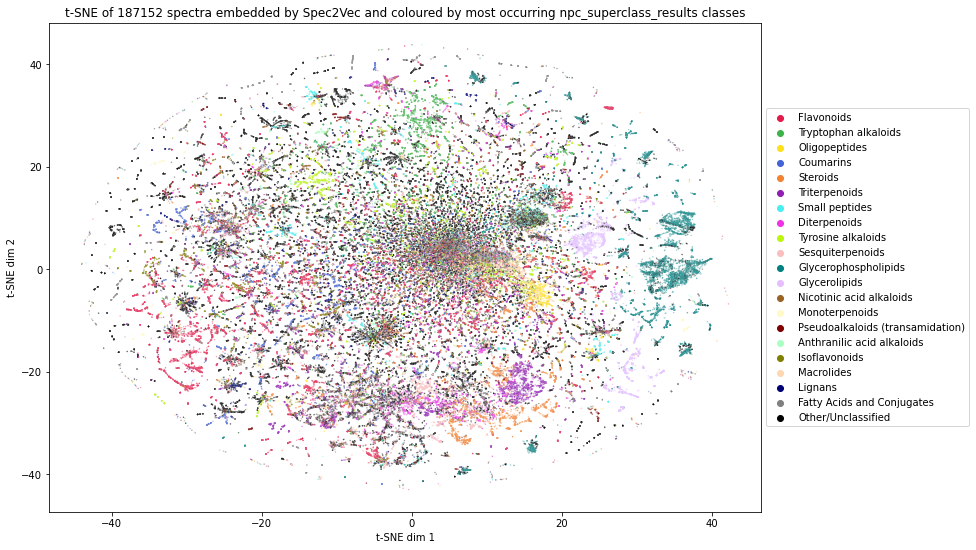

In [122]:
sel_class = new_header[i_chosen]
print("Showing classes for:", sel_class)
plt.figure(figsize=(15,9))
ax = sns.scatterplot(
    x=tsne_2d_w_res[:,0], y=tsne_2d_w_res[:,1],
    hue=chosen_classes,
    palette=colour_dict,
    legend="full", alpha=0.4, s=2) #adjust dot size

ax.set(xlabel='t-SNE dim 1', ylabel='t-SNE dim 2',
       title=f't-SNE of {len(chosen_classes)} spectra embedded by Spec2Vec and coloured by most occurring {sel_class} classes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

# Put a legend to the right side
handles, labels = ax.get_legend_handles_labels()
by_label_unsorted = dict(zip(labels, handles))
by_label = OrderedDict([(lab,by_label_unsorted[lab]) for lab in colour_dict.keys()])
ax.legend(by_label.values(), by_label.keys(), loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
# ax.legend()
plt.savefig(os.path.join(classifications_path,
                         f"plots/ALL_GNPS_210409_positive_cleaned_{sel_class}.svg"))
# plt.show()

Showing classes for: npc_superclass_results


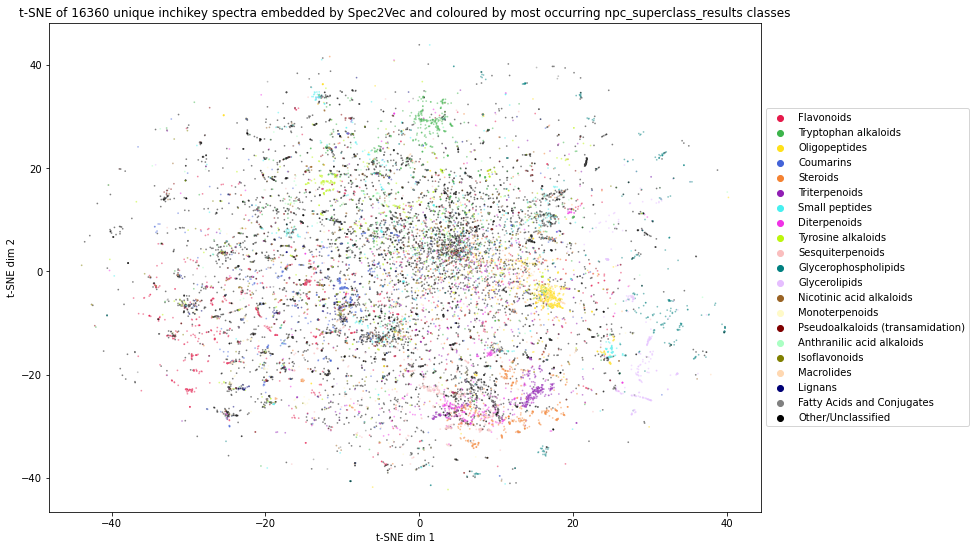

In [123]:
# UniqueInchikey - dot size and alpha are different than plot above
sel_class = new_header[i_chosen]
print("Showing classes for:", sel_class)
ui_chosen_classes = [chosen_classes[i] for i in uniq_ids]
plt.figure(figsize=(15,9))
ax = sns.scatterplot(
    x=np.take(tsne_2d_w_res[:,0], uniq_ids), y=np.take(tsne_2d_w_res[:,1], uniq_ids),
    hue=ui_chosen_classes,
    palette=colour_dict,
    legend="full", alpha=0.5, s=3) #adjust dot size

ax.set(xlabel='t-SNE dim 1', ylabel='t-SNE dim 2',
       title=f't-SNE of {len(ui_chosen_classes)} unique inchikey spectra embedded by Spec2Vec and coloured by most occurring {sel_class} classes')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
# Put a legend to the right side
handles, labels = ax.get_legend_handles_labels()
by_label_unsorted = dict(zip(labels, handles))
by_label = OrderedDict([(lab,by_label_unsorted[lab]) for lab in colour_dict.keys()])
# by_label = OrderedDict(sorted(zip(labels, handles)))
ax.legend(by_label.values(), by_label.keys(), loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)
# ax.legend()
plt.savefig(os.path.join(classifications_path,
                         f"plots/ALL_GNPS_210409_positive_cleaned_{sel_class}_unique_inchikeys.svg"))
# plt.show()

In [125]:
os.path.join(classifications_path,
                         f"plots/ALL_GNPS_210409_positive_cleaned_{sel_class}_unique_inchikeys.svg")

'/mnt/LTR_userdata/hooft001/mass_spectral_embeddings/classifications/ALL_GNPS_210409_positive/plots/ALL_GNPS_210409_positive_cleaned_npc_superclass_results_unique_inchikeys.svg'

### Old plots with matplotlib
Weighting matters!

Showing classes for: npc_pathway_results


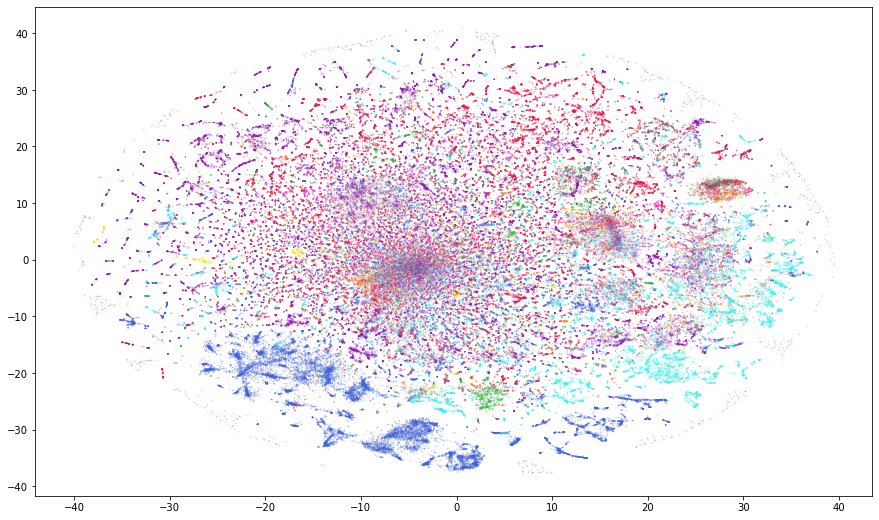

In [153]:
# Whole dataset 2D
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(tsne_2d_res[:,0],tsne_2d_res[:,1], 0.02, c=spectra_chosen_classes)
plt.show()

Showing classes for: npc_pathway_results


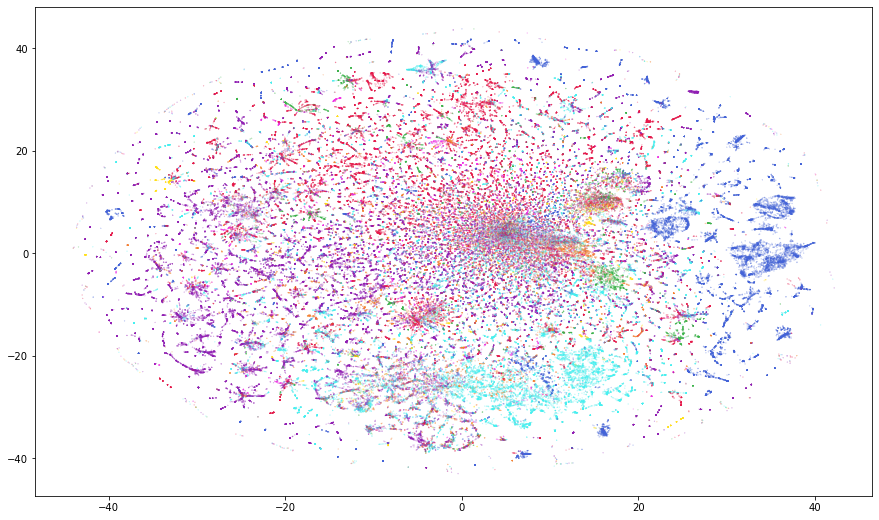

In [40]:
# Whole dataset 2D - weighted
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(tsne_2d_w_res[:,0],tsne_2d_w_res[:,1], 0.02, c=spectra_chosen_classes)
plt.show()

Showing classes for: npc_pathway_results


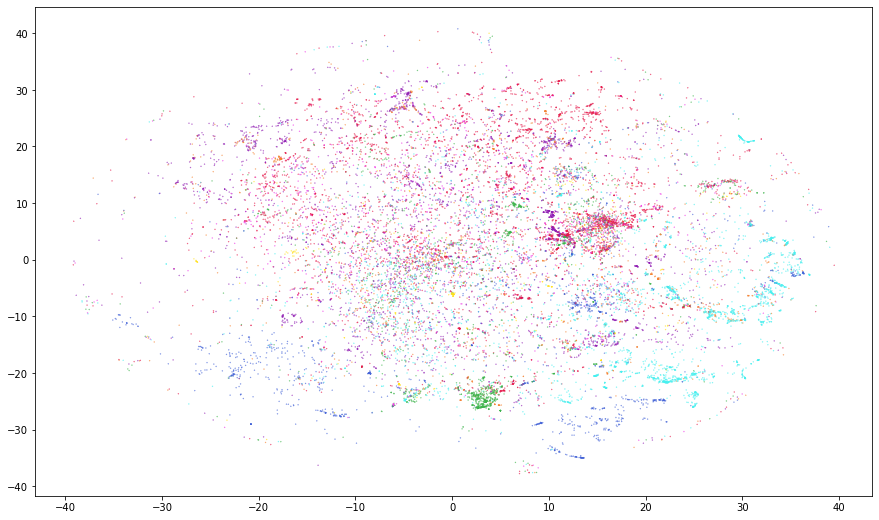

In [34]:
#UniqueInchikey 2D - note that point size is bigger here
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(np.take(tsne_2d_res[:,0], uniq_ids),np.take(tsne_2d_res[:,1], uniq_ids), 0.09,
            c=[spectra_chosen_classes[i] for i in uniq_ids])
plt.show()

Showing classes for: npc_pathway_results


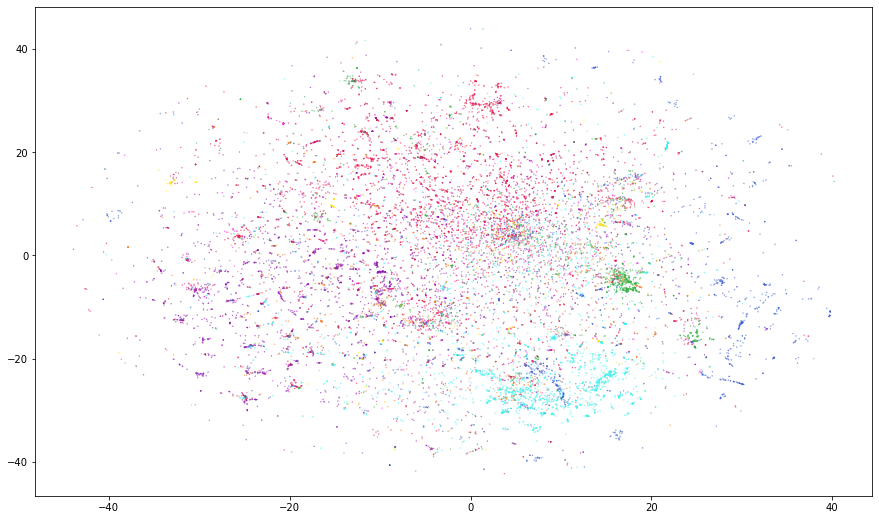

In [41]:
#UniqueInchikey 2D - weighted - note that point size is bigger here
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(np.take(tsne_2d_w_res[:,0], uniq_ids),np.take(tsne_2d_w_res[:,1], uniq_ids), 0.09,
            c=[spectra_chosen_classes[i] for i in uniq_ids])
plt.show()

Showing classes for: npc_pathway_results


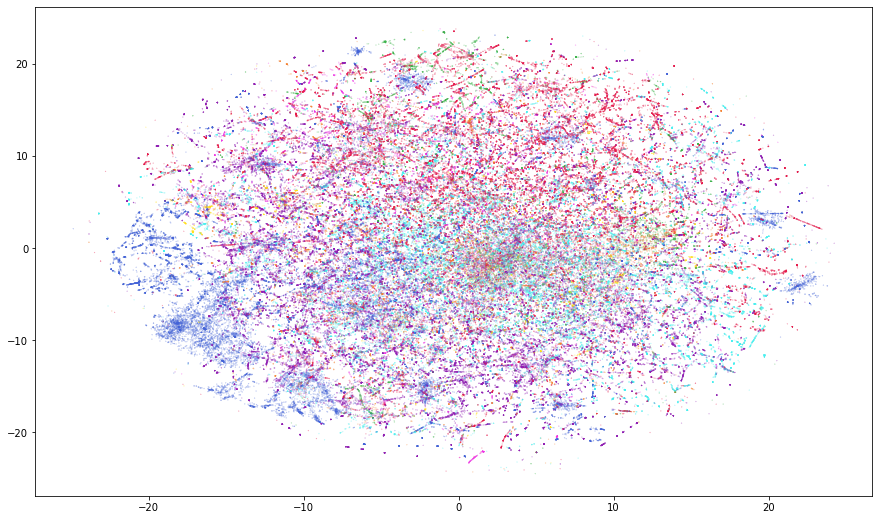

In [48]:
# Whole dataset 3D - weighted
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(tsne_3d_w_res[:,0],tsne_3d_w_res[:,1], 0.02, c=spectra_chosen_classes, label=chosen_classes)
plt.show()

Showing classes for: npc_pathway_results


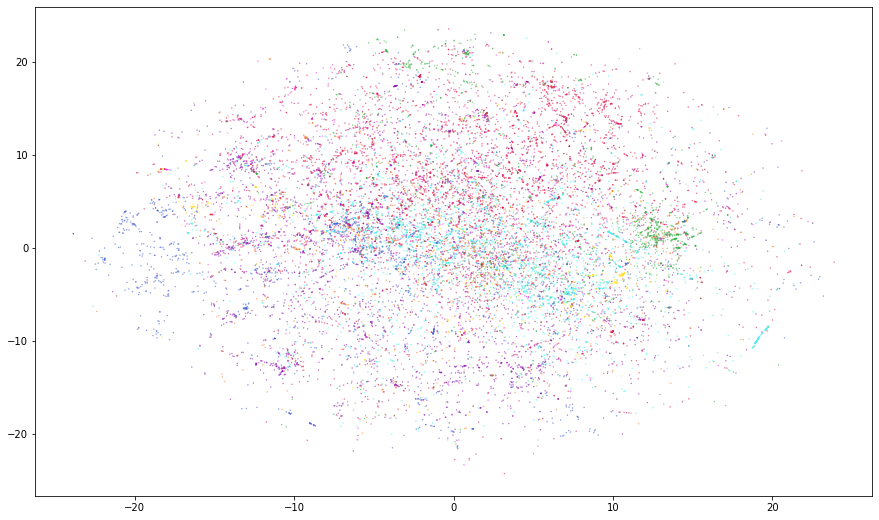

In [49]:
#UniqueInchikey 3D - weighted - point size is bigger than previous plot
print("Showing classes for:", new_header[i_chosen])
plt.figure(figsize=(15,9))
plt.scatter(np.take(tsne_3d_w_res[:,0], uniq_ids),np.take(tsne_3d_w_res[:,1], uniq_ids), 0.09,
            c=[spectra_chosen_classes[i] for i in uniq_ids])
plt.show()